This notebook contains code to create the matrix used for our FM model. It will contain, from left to right, for every rating:
- user (in dummy format)
- book (in dummy format)
- author (in dummy format)
- language (in dummy format)
- year of publication
- NLP features
- genre tags

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix, lil_matrix, save_npz, hstack, csr_matrix
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler
from sklearn.datasets import dump_svmlight_file
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratings = pd.read_csv('../ratings_us.csv') # pure ratings data
books_info = pd.read_csv('books_meta_info.csv') # book metadata
nlp = pd.read_pickle('books_with_summaries.p') # book nlp features

## Ratings

In [4]:
y = ratings.rating.values

## User Dummies

In [5]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
len(ratings.user_id.unique())

53428

In [4]:
def numpy_get_dummies(array, zero_index=False):
    sparse = csc_matrix((array.size, array.max()+1)) # creates one extra column for zero index
    sparse[np.arange(array.size), array] = 1         # so it can use the ids 1-10000 as indices
    if zero_index:
        return sparse # don't get rid of the zero column
    else:
        return sparse[:,1:] # get rid of the zero column

In [8]:
user_ids = ratings.user_id.values

In [9]:
users_dummies = numpy_get_dummies(user_ids)

C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [10]:
users_dummies.shape # n_ratings x n_users

(5976695, 53428)

In [11]:
users_dummies.sum() # sanity check

5976695.0

## Book Dummies

In [12]:
len(ratings.book_id.unique())

10000

In [13]:
book_ids = ratings.book_id.values

In [14]:
book_dummies = numpy_get_dummies(book_ids)

C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [15]:
book_dummies.shape # n_ratings x n_books

(5976695, 10000)

In [16]:
book_dummies.sum() # sanity check

5976695.0

## Author Dummies

In [17]:
books_info.head()

,Unnamed: 0,book_id,goodreads_book_id,authors,original_publication_year,language_code,Art,Biography,Business,Chick Lit,...,Romance,Science,Science Fiction,Self Help,Spirituality,Sports,Suspense,Thriller,Travel,Young Adult
0,0,1,2767052,Suzanne Collins,2008.0,eng,0.0,0.0,0.0,0.0,...,3341.0,0.0,8772.0,0.0,0.0,0.0,641.0,800.0,0.0,25968.0
1,1,2,3,"J.K. Rowling, Mary GrandPré",1997.0,eng,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14984.0
2,2,3,41865,Stephenie Meyer,2005.0,en-US,0.0,0.0,0.0,716.0,...,0.0,0.0,253.0,0.0,0.0,0.0,0.0,0.0,0.0,16640.0
3,3,4,2657,Harper Lee,1960.0,eng,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2436.0
4,4,5,4671,F. Scott Fitzgerald,1925.0,eng,0.0,0.0,0.0,0.0,...,2090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,397.0


###### Label Encode

In [6]:
books_authors = books_info[['book_id', 'authors']]

In [7]:
len(books_authors.authors.unique())

4664

In [8]:
le = LabelEncoder()
books_authors['author_id'] = le.fit_transform(books_authors.authors)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [46]:
books_authors.head()

,book_id,authors,author_id
0,1,Suzanne Collins,4222
1,2,"J.K. Rowling, Mary GrandPré",1869
2,3,Stephenie Meyer,4153
3,4,Harper Lee,1652
4,5,F. Scott Fitzgerald,1351


###### Map to Ratings and Get Dummies

In [47]:
ratings_authors = ratings.merge(books_authors[['book_id', 'author_id']], on='book_id', how='left')

In [48]:
authors_dummies = numpy_get_dummies(np.array(ratings_authors.author_id.values), zero_index=True)

C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [49]:
authors_dummies.shape # n_ratings x n_authors

(5976695, 4664)

In [50]:
authors_dummies.sum() # sanity check

5976695.0

## Language Dummies

###### Fix English codes and Missing Values

In [10]:
books_languages = books_info[['book_id', 'language_code']]

In [11]:
english = ['eng', 'en-US', 'en-GB', 'en-CA', 'en']
def map_lang(row): # maps all english codes to one, and labels NA values as unknown
    if isinstance(row.language_code, str):
        if row.language_code in english:
            return 'eng'
        else:
            return row.language_code
    else:
        if np.isnan(row.language_code):
            return 'unk'
        else:
            print(row.language_code)

In [12]:
books_languages['language_mapped'] = books_languages.apply(lambda x: map_lang(x), axis=1)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


###### Label Encode

In [13]:
le = LabelEncoder()
books_languages['language_id'] = le.fit_transform(books_languages.language_mapped)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [55]:
books_languages.head()

,book_id,language_code,language_mapped,language_id
0,1,eng,eng,2
1,2,eng,eng,2
2,3,en-US,eng,2
3,4,eng,eng,2
4,5,eng,eng,2


In [56]:
sorted(books_languages.language_id.unique()) # NOTE THESE START AT ZERO!

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

###### Map to Ratings and Get Dummies

In [57]:
ratings_languages = ratings.merge(books_languages[['book_id', 'language_id']], on='book_id', how='left')

In [58]:
language_dummies = numpy_get_dummies(np.array(ratings_languages.language_id.values), zero_index=True)

C:\Users\lohmu\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [59]:
language_dummies.shape # n_ratings x n_languages

(5976695, 22)

In [60]:
language_dummies.sum() # sanity check

5976695.0

## Year of Publication

In [16]:
books_years = books_info[['book_id', 'original_publication_year']]

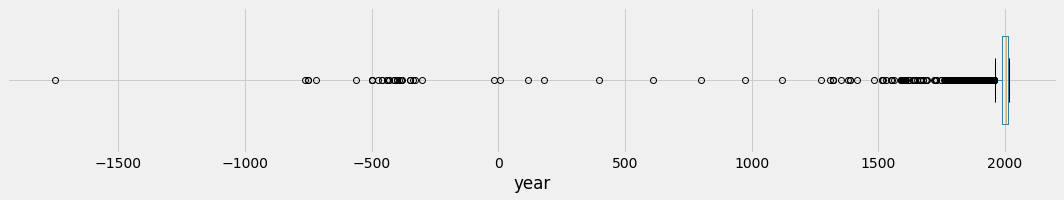

In [21]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,3))
bp = books_years.boxplot(column='original_publication_year', vert=False, return_type='dict', ax=ax, widths=0.6)
ax.set_xlabel('year')
ytickNames = plt.setp(ax, yticklabels='')
plt.tight_layout()

###### Fill NA values with median

In [22]:
year_median = books_years.original_publication_year.median()

In [23]:
year_median

2004.0

In [24]:
books_years.original_publication_year.fillna(value=year_median, inplace=True)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


###### Set values < 1700 to 1700

In [25]:
only_above_1700 = pd.concat([books_years.book_id, 
                             books_years.original_publication_year.where(
                                books_years.original_publication_year > 1700, other=1700)], axis=1)

In [26]:
only_above_1700.head()

,book_id,original_publication_year
0,1,2008.0
1,2,1997.0
2,3,2005.0
3,4,1960.0
4,5,1925.0


In [27]:
def years_ago(x):
    return 2017-x

In [28]:
def normalize_year(x):
    return 1-(x/318.0)

In [29]:
only_above_1700['years_ago'] = only_above_1700.original_publication_year.apply(years_ago)
only_above_1700['normalized'] = only_above_1700.years_ago.apply(normalize_year)

In [67]:
# Normalize the year to a value from 0 to 1 (1 is 2017, close to 0 (but never 0) is 1700)
# def normalize_year(x):
#     if np.isnan(x):
#         return np.nan
#     if int(x)<1700:
#         x=1700
#     return 1-((2017-x)/318.0)
# only_above_1700['original_publication_year']=only_above_1700.original_publication_year.apply(normalize_year)

In [30]:
only_above_1700.head()

,book_id,original_publication_year,years_ago,normalized
0,1,2008.0,9.0,0.971698
1,2,1997.0,20.0,0.937107
2,3,2005.0,12.0,0.962264
3,4,1960.0,57.0,0.820755
4,5,1925.0,92.0,0.710692


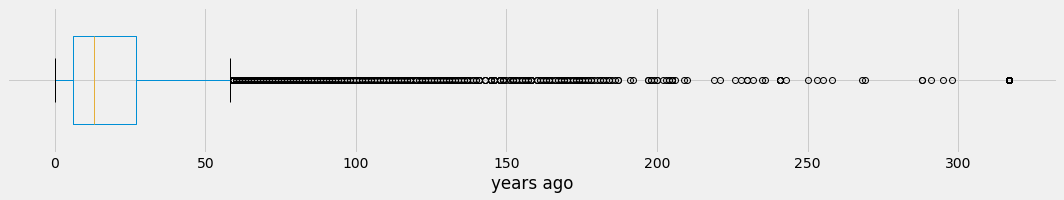

In [32]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,3))
bp = only_above_1700.boxplot(column='years_ago', vert=False, return_type='dict', ax=ax, widths=0.6)
ax.set_xlabel('years ago')
ytickNames = plt.setp(ax, yticklabels='')
plt.tight_layout()

###### Map to Ratings

In [69]:
ratings_years = ratings.merge(only_above_1700[['book_id', 'normalized']], on='book_id', how='left').drop(['user_id', 'book_id', 'rating'], axis=1)

In [70]:
ratings_years.shape # n_ratings x 1

(5976695, 1)

###### Make Sparse Matrix

In [71]:
years_sparse = csc_matrix(ratings_years)

## NLP Features

In [36]:
books_summaries = pd.read_pickle('books_with_summaries.p')

In [37]:
books_summaries.head()

,book_id,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,258,-0.230597,-0.250082,-0.377935,-0.266002,-0.304168,-0.343982,-0.243430,-0.288574,-0.235490,...,2.251627,-0.114333,1.656405,1.347895,0.134338,-0.168178,0.339720,-0.092151,-1.892633,0.210597
1,4081,-0.308547,-0.288131,-0.474792,0.096718,-0.311331,-0.297464,-0.357227,0.005336,-0.166258,...,-4.709953,-2.067705,-2.183916,-1.984647,-2.578708,0.348261,0.182132,0.210395,0.877238,1.475320
2,260,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,9296,-0.240595,-0.186942,-0.019210,-0.341454,-0.223834,-0.308025,-0.311226,-0.154156,-0.214751,...,1.545850,-0.368972,-2.457852,-0.854603,3.318846,0.407702,2.294161,0.442469,3.453820,-0.043973
4,2318,-0.262850,-0.283931,-0.338522,-0.293817,-0.228251,-0.293628,-0.268385,-0.141414,-0.178740,...,-2.150216,2.403672,-1.876621,3.148182,-1.488503,-4.015573,-0.856176,-0.201446,-0.743828,1.455489


In [38]:
books_summaries.columns

Index(['book_id',         0,         1,         2,         3,         4,
               5,         6,         7,         8,         9,        10,
              11,        12,        13,        14,        15,        16,
              17,        18,        19,        20,        21,        22,
              23,        24,        25,        26,        27,        28,
              29,        30,        31,        32,        33,        34,
              35,        36,        37,        38,        39],
      dtype='object')

#### Scale the Features
Scale first five columns of the NLP features (both models) to values from 0 to 1. 

In [40]:
scaler = MinMaxScaler()
books_summaries[[0, 1, 2, 3, 4, 20, 21, 22, 23, 24]] = scaler.fit_transform(books_summaries[[0, 1, 2, 3, 4, 20, 21, 22, 23, 24]])

In [41]:
books_summaries.head()

,book_id,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,258,0.004051,0.000354,0.014170,0.020822,0.017178,-0.343982,-0.243430,-0.288574,-0.235490,...,2.251627,-0.114333,1.656405,1.347895,0.134338,-0.168178,0.339720,-0.092151,-1.892633,0.210597
1,4081,0.003982,0.000319,0.014007,0.021305,0.017169,-0.297464,-0.357227,0.005336,-0.166258,...,-4.709953,-2.067705,-2.183916,-1.984647,-2.578708,0.348261,0.182132,0.210395,0.877238,1.475320
2,260,0.004343,0.000672,0.014975,0.021310,0.017692,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,9296,0.004042,0.000411,0.014774,0.020722,0.017280,-0.308025,-0.311226,-0.154156,-0.214751,...,1.545850,-0.368972,-2.457852,-0.854603,3.318846,0.407702,2.294161,0.442469,3.453820,-0.043973
4,2318,0.004023,0.000323,0.014237,0.020785,0.017275,-0.293628,-0.268385,-0.141414,-0.178740,...,-2.150216,2.403672,-1.876621,3.148182,-1.488503,-4.015573,-0.856176,-0.201446,-0.743828,1.455489


In [42]:
books_summaries=books_summaries[['book_id',0, 1, 2, 3, 4, 20, 21, 22, 23, 24]]

###### Merge with Ratings

In [95]:
ratings_nlp = ratings.merge(books_summaries, on='book_id', how='left').drop(['user_id', 'book_id', 'rating'], axis=1)

In [96]:
ratings_nlp.shape # n_ratings x n_nlp_features

(5976695, 10)

###### Make Sparse Matrix

In [97]:
nlp_sparse = csc_matrix(ratings_nlp)

## Genre Mapping

###### Combine Genres into Broader Categories

In [44]:
def map_genres(row):
    new_genres = {}
    new_genres['book_id'] = row.book_id
    new_genres['art_music'] = row.Art + row.Music + row.Poetry
    new_genres['biography'] = row.Biography + row.Memoir
    new_genres['business'] = row.Business + row.Psychology
    new_genres['romance'] = row['Chick Lit'] + row.Romance
    new_genres['children'] = row["Children's"] + row['Young Adult']
    new_genres['religion_philosophy'] = row.Christian + row.Religion + row.Philosophy + row.Spirituality
    new_genres['classics'] = row.Classics
    new_genres['comics'] = row.Comics + row['Graphic Novels'] + row.Manga
    new_genres['contemporary'] = row.Contemporary
    new_genres['cookbooks'] = row.Cookbooks
    new_genres['mystery'] = row.Crime + row.Horror + row.Mystery + row.Suspense + row.Thriller
    new_genres['scifi_fantasy'] = row.Fantasy + row.Paranormal + row['Science Fiction']
    new_genres['fiction'] = row.Fiction
    new_genres['gay_lesbian'] = row['Gay and Lesbian']
    new_genres['hist_fiction'] = row['Historical Fiction']
    new_genres['history'] = row.History
    new_genres['humor'] = row['Humor and Comedy']
    new_genres['nonfiction'] = row.Nonfiction
    new_genres['science'] = row.Science
    new_genres['self_help'] = row['Self Help']
    new_genres['sports'] = row.Sports
    new_genres['travel'] = row.Travel
    return new_genres

In [45]:
books_genres = pd.DataFrame(list(books_info.apply(lambda x: map_genres(x), axis=1)))

In [46]:
books_genres.head()

,art_music,biography,book_id,business,children,classics,comics,contemporary,cookbooks,fiction,...,humor,mystery,nonfiction,religion_philosophy,romance,science,scifi_fantasy,self_help,sports,travel
0,0.0,0.0,1,0.0,25968.0,0.0,0.0,382.0,0.0,13819.0,...,0.0,1441.0,0.0,0.0,3341.0,0.0,19608.0,0.0,0.0,0.0
1,0.0,0.0,2,0.0,16755.0,1898.0,0.0,397.0,0.0,13239.0,...,0.0,657.0,0.0,0.0,0.0,0.0,48401.0,0.0,0.0,0.0
2,0.0,0.0,3,0.0,16640.0,0.0,0.0,503.0,0.0,6298.0,...,0.0,462.0,0.0,0.0,716.0,0.0,19721.0,0.0,0.0,0.0
3,0.0,0.0,4,0.0,2436.0,31068.0,0.0,253.0,0.0,879.0,...,0.0,555.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,5,0.0,397.0,32061.0,0.0,0.0,0.0,15360.0,...,0.0,0.0,0.0,0.0,2090.0,0.0,0.0,0.0,0.0,0.0


###### L1 Normalize By Row

In [47]:
new_genres = books_genres.drop('book_id', axis=1).columns

In [48]:
books_genres_norm = pd.DataFrame(Normalizer(norm='l1').fit_transform(books_genres.drop('book_id', axis=1)), columns=new_genres)

In [49]:
books_genres_norm.head()

,art_music,biography,business,children,classics,comics,contemporary,cookbooks,fiction,gay_lesbian,...,humor,mystery,nonfiction,religion_philosophy,romance,science,scifi_fantasy,self_help,sports,travel
0,0.0,0.0,0.0,0.402237,0.000000,0.0,0.005917,0.0,0.214052,0.0,...,0.0,0.022321,0.0,0.0,0.051751,0.0,0.303722,0.0,0.0,0.0
1,0.0,0.0,0.0,0.205969,0.023332,0.0,0.004880,0.0,0.162747,0.0,...,0.0,0.008077,0.0,0.0,0.000000,0.0,0.594994,0.0,0.0,0.0
2,0.0,0.0,0.0,0.375282,0.000000,0.0,0.011344,0.0,0.142039,0.0,...,0.0,0.010419,0.0,0.0,0.016148,0.0,0.444768,0.0,0.0,0.0
3,0.0,0.0,0.0,0.060441,0.770842,0.0,0.006277,0.0,0.021809,0.0,...,0.0,0.013770,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007591,0.612998,0.0,0.000000,0.0,0.293679,0.0,...,0.0,0.000000,0.0,0.0,0.039960,0.0,0.000000,0.0,0.0,0.0


###### Drop Values < 0.1

In [50]:
only_above_10 = books_genres_norm.where(books_genres_norm > 0.1, other=0)

###### Normalize Again

In [51]:
books_genres_norm2 = pd.concat([books_genres.book_id, 
                                pd.DataFrame(Normalizer(norm='l1').fit_transform(only_above_10), 
                                             columns=new_genres)], axis=1)

In [52]:
books_genres_norm2.head()

,book_id,art_music,biography,business,children,classics,comics,contemporary,cookbooks,fiction,...,humor,mystery,nonfiction,religion_philosophy,romance,science,scifi_fantasy,self_help,sports,travel
0,1,0.0,0.0,0.0,0.437209,0.000000,0.0,0.0,0.0,0.232663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.330129,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.213725,0.000000,0.0,0.0,0.0,0.168876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.617399,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.390070,0.000000,0.0,0.0,0.0,0.147636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.462294,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.000000,0.867749,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.000000,0.676093,0.0,0.0,0.0,0.323907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


###### Map to Ratings

In [107]:
ratings_genres = ratings.merge(books_genres_norm2, on='book_id', how='left').drop(['user_id', 'book_id', 'rating'], axis=1)

In [108]:
ratings_genres.shape # n_ratings x n_genres

(5976695, 22)

In [123]:
ratings_genres.columns

Index(['art_music', 'biography', 'business', 'children', 'classics', 'comics',
       'contemporary', 'cookbooks', 'fiction', 'gay_lesbian', 'hist_fiction',
       'history', 'humor', 'mystery', 'nonfiction', 'religion_philosophy',
       'romance', 'science', 'scifi_fantasy', 'self_help', 'sports', 'travel'],
      dtype='object')

In [109]:
ratings_genres.sum().sum() # sanity check - rounding errors?

5975780.000002879

###### Make Sparse Matrix

In [110]:
genres_sparse = csc_matrix(ratings_genres)

## Concatenate Everything!

In [54]:
def concatenate_csc_matrices_by_columns(matrix1, matrix2):
    new_data = np.concatenate((matrix1.data, matrix2.data))
    new_indices = np.concatenate((matrix1.indices, matrix2.indices))
    new_ind_ptr = matrix2.indptr + len(matrix1.data)
    new_ind_ptr = new_ind_ptr[1:]
    new_ind_ptr = np.concatenate((matrix1.indptr, new_ind_ptr))

    return csc_matrix((new_data, new_indices, new_ind_ptr))

In [112]:
temp1 = concatenate_csc_matrices_by_columns(users_dummies, book_dummies)
temp2 = concatenate_csc_matrices_by_columns(temp1, authors_dummies)
#temp3 = concatenate_csc_matrices_by_columns(temp2, language_dummies)
temp3 = concatenate_csc_matrices_by_columns(temp2, language_dummies)
temp4 = concatenate_csc_matrices_by_columns(temp3, years_sparse)
temp5 = concatenate_csc_matrices_by_columns(temp4, nlp_sparse)
all_features = concatenate_csc_matrices_by_columns(temp5, genres_sparse)
#all_features = concatenate_csc_matrices_by_columns(temp4, genres_sparse)

In [113]:
#n_users + n_books + n_authors + n_languages + 1 years column + 40 nlp features + n_genres
53428 + 10000 + 4664 + 22 + 1 + 10 + 22
#53428 + 10000 + 4664+22 + 1  + 22

68147

In [114]:
all_features.shape # BOOM

(5976695, 68147)

## Train/Test Sets

In [115]:
val_test_size = round(0.15 * all_features.shape[0])

In [116]:
X_temp, X_test, y_temp, y_test = train_test_split(all_features, y, test_size=val_test_size, random_state=42)

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_test_size, random_state=42)

## Write Files

In [118]:
train_file = 'libfm_train_normnlp.txt'
val_file = 'libfm_val_normnlp.txt'
test_file = 'libfm_test_normnlp.txt'

In [119]:
with open(train_file, 'wb') as f:
    dump_svmlight_file(X_train, y_train, f=f)

In [120]:
with open(val_file, 'wb') as f:
    dump_svmlight_file(X_val, y_val, f=f)

In [121]:
with open(test_file, 'wb') as f:
    dump_svmlight_file(X_test, y_test, f=f)

## Calls to Generate All Feature Combinations
The following section was used to generate feature combinations that would allow us to evaluate incremental value of each feature.

In [122]:
# def generate_files(authors, language, years, nlp, genres, ending):
#     feats = concatenate_csc_matrices_by_columns(users_dummies, book_dummies)
#     if authors:
#         feats = concatenate_csc_matrices_by_columns(feats, authors_dummies)
#     if language:
#         feats = concatenate_csc_matrices_by_columns(feats, language_dummies)
#     if years:
#         feats = concatenate_csc_matrices_by_columns(feats, years_sparse)
#     if nlp:
#         feats = concatenate_csc_matrices_by_columns(feats, nlp_sparse)
#     if genres:
#         feats = concatenate_csc_matrices_by_columns(feats, genres_sparse)
    
#     val_test_size = round(0.15 * feats.shape[0])
#     X_temp, X_test, y_temp, y_test = train_test_split(feats, y, test_size=val_test_size, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_test_size, random_state=42)
    
#     train_file = 'libfm_train_{}.txt'.format(ending)
#     val_file = 'libfm_val_{}.txt'.format(ending)
#     test_file = 'libfm_test_{}.txt'.format(ending)
    
#     with open(train_file, 'wb') as f:
#         dump_svmlight_file(X_train, y_train, f=f)
    
#     with open(val_file, 'wb') as f:
#         dump_svmlight_file(X_val, y_val, f=f)
    
#     with open(test_file, 'wb') as f:
#         dump_svmlight_file(X_test, y_test, f=f)

In [125]:
# generate_files(False,False,False,False,False,'solo')

In [126]:
# generate_files(True,False,False,False,False,'authors')

In [127]:
# generate_files(False,True,False,False,False,'language')

In [128]:
# generate_files(False,False,True,False,False,'years')

In [129]:
# generate_files(False,False,False,True,False,'nlp')

In [130]:
# generate_files(False,False,False,False,True,'genres')

## Make Model Features File

In [5]:
books_book_dummies = numpy_get_dummies(np.array(range(1, 10001)))

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [9]:
books_authors_dummies = numpy_get_dummies(books_authors.author_id.values, zero_index=True)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [14]:
books_languages_dummies = numpy_get_dummies(books_languages.language_id.values, zero_index=True)

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [35]:
books_years_sparse = csr_matrix(only_above_1700.normalized.values).T

In [43]:
books_summaries_sparse = csc_matrix(books_summaries.drop('book_id', axis=1))

In [53]:
books_genres_sparse = csc_matrix(books_genres_norm2.drop('book_id', axis=1))

In [55]:
temp1 = concatenate_csc_matrices_by_columns(books_book_dummies, books_authors_dummies)
temp2 = concatenate_csc_matrices_by_columns(temp1, books_languages_dummies)
temp3 = concatenate_csc_matrices_by_columns(temp2, books_years_sparse)
temp4 = concatenate_csc_matrices_by_columns(temp3, books_summaries_sparse)
model_features = concatenate_csc_matrices_by_columns(temp4, books_genres_sparse)
print(model_features.shape)

(10000, 14719)


In [57]:
model_features_genres_only = concatenate_csc_matrices_by_columns(books_book_dummies, books_genres_sparse)

In [56]:
save_npz('model_features.npz', model_features) #all features

In [58]:
save_npz('model_features_genres_only.npz', model_features_genres_only)